# Using our facial recognition tool

We trained a couple facial recognition models, let's put them to work!

First: we need to be able to **get faces out of pictures**. We're going to be using [MTCNN](https://github.com/ipazc/mtcnn), which is a neural network that does absolutely nothing but find faces in pictures! We don't need to train it or do anything like that, it's used just like a normal library.

In [169]:
!pip install mtcnn

In [170]:
from mtcnn import MTCNN
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

detector = MTCNN()

def get_faces(filename, image_size):
  image = plt.imread(filename)
  faces_coords = detector.detect_faces(image)

  faces = []
  for coords in faces_coords:
    x1, y1, width, height = coords['box']
    x1 = max(x1, 0)
    y1 = max(y1, 0)
    x2, y2 = x1 + width, y1 + height
    face = image[y1:y2, x1:x2]
    face = Image.fromarray(face).resize(image_size)
    face = np.asarray(face)
    faces.append(face)

  return faces

We can test it out by downloading an image of Mitch McConnell.

In [171]:
# Download an image
!wget --quiet https://i.insider.com/606b293ca7d803001963eb9f?width=700 -O mitch.jpg

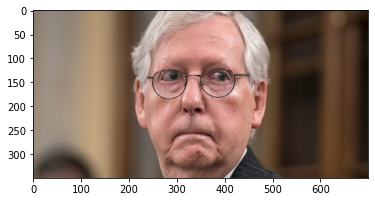

In [172]:
img = plt.imread("mitch.jpg")
plt.imshow(img)

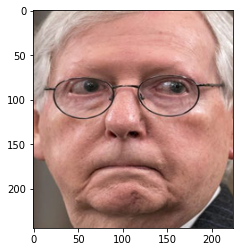

In [174]:
# When we use get_faces, we also need to tell it
# what size images we want back
size = (224, 244)

faces = get_faces("mitch.jpg", size)

# Look at the first face it found
plt.imshow(faces[0])

### Multiple faces

It will also work if there are multiple faces! We'll download Mitch and Nancy Pelosi being grumpy.

In [175]:
!wget --quiet "https://static.politico.com/00/fc/273866e64d898ca21c029af9d2f2/200715-pelosi-mcconnell-ap-773.jpg" -O grumpy.jpg

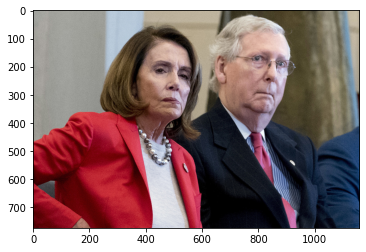

In [176]:
img = plt.imread("grumpy.jpg")
plt.imshow(img)

In [178]:
# Return faces as 100x100 images because we don't
# want them to take up the whole screen or anything!
size = (224, 224 )

faces = get_faces("grumpy.jpg", size)
len(faces)

2

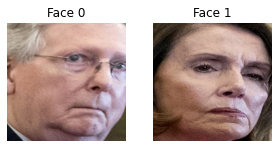

In [179]:
# Loop through each face, display it
plt.figure(figsize=(10, 10))
for i, face in enumerate(faces):
  label = f"Face {i}"
  ax = plt.subplot(4, 4, i + 1)

  plt.imshow(face)
  plt.title(f"Face {i}")
  plt.axis("off")

## Doing facial recognition

To do facial recognition, we need to bring in the models we trained. They live on our Google Drive, so let's connect that now.

In [181]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [182]:
!ls /content/gdrive/MyDrive/models

congress_labels.json  face_recognition_v1  face_recognition_v2


Now we'll import our first model right from Google Drive!

In [183]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.load_model('/content/gdrive/MyDrive/models/face_recognition_v1')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              42626560  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 536)               1098264   
Total params: 43,724,824
Trainable params: 43,627,160
Non-trainable params: 97,664
_________________________________________________________________


This is the code we used in class to make a prediction. It worked then, but now it gives us an error, because something is wrong with our face images that makes it incompatible with our model. **You'll need to change something up above, then re-run this code.**

In [186]:
# Make a prediction!!!
img = faces[0]
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
# Divide by 255 to make RGB values 0-1 instead of 0-255
scores = model.predict(img_array / 255)[0]
scores

ValueError: ignored

Once it's finally working, it gives you a lot of awful numbers. **Each number is one probability score for each member of Congress**. We can ask for the index of the largest, just like we did with gibbons and goldfish and all of that.

In [ ]:
np.argmax(scores)

Okay, it's that's the number of the person it is. We saved the class labels separately, let's read them in now.

In [ ]:
import json

with open('/content/gdrive/MyDrive/models/congress_labels.json', 'r') as fp:
  class_names = json.load(fp)

class_names[:5]

**Who is it predicting as the owner of the face?** Is that correct?

**How certain is our model that this is the right answer?**

*Hint: what variable has the probabilities?*

If it isn't very sure or it isn't very correct, we can take a look at the second or third most likely label. Let's steal some code from class and look at the **top 5 likeliest labels**.

In [ ]:
predictions = np.argsort(scores)[::-1]
for pred in predictions[:5]:
  score = scores[pred]
  label = class_names[pred]
  print(f"{label}: {score:.2%}")

How do we feel about it? Did it do a good job?

Now let's find the likeliest predictions for the second face in the image.

**Start by copying the "Make a prediction!!!" code, and finish by listing the top 5 most likely labels.** Make sure it's doing a prediction for the second face in the image this time – your results should be different.

In [ ]:
# Get your prediction scores


In [ ]:
# Top 5 labels


### Let's do this all at once

Because we love convenience, let's display the image, get the predictions, loop through, display it all.

Run the code below. It should work fine.

In [ ]:
from IPython.display import display

# Filename of the image to look at
filename = "grumpy.jpg"

# Size of the images
size = (224, 224)

# Print the image
display(Image.open(filename).resize((400,400)))

# Grab the faces
faces = get_faces(filename, size)

# Make predictions for all faces at once
# Divide by 255 to make RGB values 0-1 instead of 0-255
predictions = model.predict(np.array(faces) / 255)

# Loop through each face and the predictions
for face, scores in zip(faces, predictions):
  print("---------")
  # Display the face
  display(Image.fromarray(face))

  # Show the top 5 scores
  predictions = np.argsort(scores)[::-1]
  for pred in predictions[:5]:
    score = scores[pred]
    label = class_names[pred]
    print(f"* {label}: {score:.2%}")


Cool, yeah?

# Trying our other model

Our first model and our second model performed very differently during training, so let's try the second model now.

**Re-use the `load_model` code from up above. Make a small edit to load v2 of our face recognition software.**

In [ ]:
# Load v2 of the model


We'll put the downloading stuff down here, too, in case you want to try a different image.

In [ ]:
# Download the image
!wget --quiet "https://static.politico.com/00/fc/273866e64d898ca21c029af9d2f2/200715-pelosi-mcconnell-ap-773.jpg" -O grumpy.jpg

In [ ]:
# Preview the image
img = plt.imread("grumpy.jpg")
plt.imshow(img)

In the cell below, copy and paste "Let's do this all at once" code to make predictions for all of the faces in the image.

**You'll get an error**. Even though v1 and v2 might both be ResNet50, there are a couple differences. One is that v1 is trained on ImageNet and v2 is trained on FaceNet, but there's ooooone more difference which will make you change one line of code...

**Edit the "Let's do this all at once" code below to successfully make predictions.**

Did it do any better?